## Attention

### 가중합 WeightSum 계층 구현 : 맥락벡터를 구하는 계층

In [1]:
import numpy as np

class WeightSum:
    def __init__(self):
        self.params, self.grads = [],[]
        self.cache = None
        
    def forward(self, hs, a):  # hs : (N,T,H)
        N,T,H = hs.shape
        
        ar = a.reshape(N,T,1) # .repeat(H, axis=2)는 생략가능
        t = hs * ar
        c = np.sum(t, axis=1)  # (N,H)
        
        self.cache = (hs, ar)
        return c
    
    def backward(self,dc) :
        hs, ar = self.cache
        N,T,H = hs.shape
        
        dt = dc.reshape(N,1,H).repeat(T,axis=1)   # sum의 역전파, 출력: (N,T,H)
        dar = dt * hs       # (N,T,H)
        dhs = dt * ar       # (N,T,H)
        da = np.sum(dar, axis=2)    # repeat의 역전파, 출력 :(N,T)
        
        return dhs, da

In [2]:
from nn_layers import softmax, Softmax

In [3]:
# 각단어의 가중치를 구하는 class
class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [],[]
        self.softmax = Softmax()
        self.cache = None
        
    def forward(self, hs, h) :  # hs: (N,T,H),  h : (N,H)
        N,T,H = hs.shape
        
        hr = h.reshape(N,1,H) # .repeat(T,axis=1)는 생략가능
        t = hs * hr           #  (N,T,H)
        s = np.sum(t, axis=2) #  (N,T)
        a = self.softmax.forward(s)  # (N,T)
        
        self.cache = (hs,hr)
        return a
    
    def backward(self, da) :
        hs,hr = self.cache
        N,T,H = hs.shape
        
        ds = self.softmax.backward(da)    # (N,T)
        dt = ds.reshape(N,T,1).repeat(H,axis=2)  # (N,T,H)
        dhs = dt * hr              # (N,T,H)
        dhr = dt * hs              # (N,T,H)
        dh = np.sum(dhr, axis=1)   # (N,H)
        
        return dhs, dh     # (N,T,H) , (N,H)

In [4]:
class Attention:  # AttentionWeight과 WeightSum으로 구성
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None

    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)
        out = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a
        return out

    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh

In [5]:
class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None

    def forward(self, hs_enc, hs_dec):  # hs_enc : Encoder의 출력값, hs_dec:하위 LSTM 출력값 이 입력된다
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []

        for t in range(T):
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:,t,:])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight) # Attention 계층의 각 단어의 가중치를 리스트에 저장

        return out

    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)

        for t in range(T):
            layer = self.layers[t]     # Attention계층
            dhs, dh = layer.backward(dout[:, t, :])  # dhs는 Encoder에 전달, dh는 LSTM계층으로 전달
            dhs_enc += dhs
            dhs_dec[:,t,:] = dh        # h: LSTM 계층의 출력이므로

        return dhs_enc, dhs_dec

In [6]:
from nn_layers import Encoder, Seq2seq

In [7]:
class AttentionEncoder(Encoder): # Encoder class 상속받음
    
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs # 모든 hs 반환 (N,T,H)

    def backward(self, dhs):
        dout = self.lstm.backward(dhs)  # dhs 그대로 사용
        dout = self.embed.backward(dout)
        return dout
    
class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention()     # 추가된 부분
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, enc_hs):
        h = enc_hs[:,-1]   # Encoder의 마지막줄
        self.lstm.set_state(h) # TimeLSTM의 self.h 에 저장

        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out) # TimeLSTM의 self.h와 함께 처리
        c = self.attention.forward(enc_hs, dec_hs)
        out = np.concatenate((c, dec_hs), axis=2)  # TimeAttention계층의 출력과 LSTM계층의 출력을 합쳐서 Affine계층에 입력
        score = self.affine.forward(out)

        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2   # Affine계층 입력시에 concatenate으로 합쳤기 때문에 반으로 나눈다, dec_hs:(N,T,H)

        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]  # concatenate의 역전파
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1  # Affine의 역전파 출력과 Attention 역전파의 출력을 합하여 LSTM에 전달
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh  # Encoder의 마지막줄 + dh
        self.embed.backward(dout)

        return denc_hs

    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]   # Encoder의 마지막줄
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))

            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)  # LSTM출력
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled

In [8]:
class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(V, D, H)
        self.decoder = AttentionDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

In [9]:
import matplotlib.pyplot as plt
from dataset import sequence
from nn_layers import Softmax, Adam ,Trainer ,TimeEmbedding ,TimeSoftmaxWithLoss,TimeLSTM,TimeAffine
from nn_layers import eval_seq2seq,Seq2seq ,PeekySeq2seq

# date.txt : 날짜 형식 변환 데이터, 5만개의 날짜 변환 학습 데이터
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()
print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)
print(x_train[0])
print(t_train[0])


(45000, 29) (45000, 11)
(5000, 29) (5000, 11)
[ 8 22  9 22  9  8  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7]
[14 11 12  9  8 15 16  8 15 16  9]


In [10]:
# 입력 문장 반전
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
# max_epoch = 1
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
# model = Seq2seq(vocab_size, wordvec_size, hidden_size)  
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

# 약 1시간 소요
acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('정확도 %.3f%%' % (acc * 100))   # 정확도 100.000%, Attention이 가장 유리하다


model.save_params()

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 4.08
| 에폭 1 |  반복 21 / 351 | 시간 13[s] | 손실 3.09
| 에폭 1 |  반복 41 / 351 | 시간 26[s] | 손실 1.90
| 에폭 1 |  반복 61 / 351 | 시간 38[s] | 손실 1.72
| 에폭 1 |  반복 81 / 351 | 시간 50[s] | 손실 1.46
| 에폭 1 |  반복 101 / 351 | 시간 63[s] | 손실 1.19
| 에폭 1 |  반복 121 / 351 | 시간 76[s] | 손실 1.14
| 에폭 1 |  반복 141 / 351 | 시간 88[s] | 손실 1.09
| 에폭 1 |  반복 161 / 351 | 시간 100[s] | 손실 1.06
| 에폭 1 |  반복 181 / 351 | 시간 112[s] | 손실 1.04
| 에폭 1 |  반복 201 / 351 | 시간 124[s] | 손실 1.03
| 에폭 1 |  반복 221 / 351 | 시간 136[s] | 손실 1.02
| 에폭 1 |  반복 241 / 351 | 시간 148[s] | 손실 1.02
| 에폭 1 |  반복 261 / 351 | 시간 160[s] | 손실 1.01
| 에폭 1 |  반복 281 / 351 | 시간 172[s] | 손실 1.00
| 에폭 1 |  반복 301 / 351 | 시간 184[s] | 손실 1.00
| 에폭 1 |  반복 321 / 351 | 시간 197[s] | 손실 1.00
| 에폭 1 |  반복 341 / 351 | 시간 208[s] | 손실 1.00
Q 10/15/94                     
T 1994-10-15
X 1978-08-11
---
Q thursday, november 13, 2008  
T 2008-11-13
X 1978-08-11
---
Q Mar 25, 2003                 
T 2003-03-25
X 1978-08-11
---
Q Tuesday, November

Q 8/30/07                      
T 2007-08-30
O 2007-08-30
---
Q 10/28/13                     
T 2013-10-28
O 2013-10-28
---
Q sunday, november 6, 2016     
T 2016-11-06
O 2016-11-06
---
정확도 99.920%
| 에폭 7 |  반복 1 / 351 | 시간 0[s] | 손실 0.00
| 에폭 7 |  반복 21 / 351 | 시간 11[s] | 손실 0.00
| 에폭 7 |  반복 41 / 351 | 시간 23[s] | 손실 0.00
| 에폭 7 |  반복 61 / 351 | 시간 34[s] | 손실 0.00
| 에폭 7 |  반복 81 / 351 | 시간 45[s] | 손실 0.00
| 에폭 7 |  반복 101 / 351 | 시간 57[s] | 손실 0.00
| 에폭 7 |  반복 121 / 351 | 시간 68[s] | 손실 0.00
| 에폭 7 |  반복 141 / 351 | 시간 79[s] | 손실 0.00
| 에폭 7 |  반복 161 / 351 | 시간 90[s] | 손실 0.00
| 에폭 7 |  반복 181 / 351 | 시간 102[s] | 손실 0.00
| 에폭 7 |  반복 201 / 351 | 시간 113[s] | 손실 0.00
| 에폭 7 |  반복 221 / 351 | 시간 124[s] | 손실 0.00
| 에폭 7 |  반복 241 / 351 | 시간 135[s] | 손실 0.00
| 에폭 7 |  반복 261 / 351 | 시간 146[s] | 손실 0.00
| 에폭 7 |  반복 281 / 351 | 시간 158[s] | 손실 0.00
| 에폭 7 |  반복 301 / 351 | 시간 169[s] | 손실 0.00
| 에폭 7 |  반복 321 / 351 | 시간 180[s] | 손실 0.00
| 에폭 7 |  반복 341 / 351 | 시간 192[s] | 손실 0.00
Q 10/15/

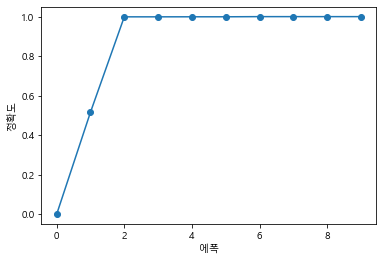

In [11]:
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(-0.05, 1.05)
plt.show()